<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Transfer_Learning_with_NSL_and_TF_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow recently released [Neural Structured Learning](https://www.tensorflow.org/neural_structured_learning). 

Neural Structured Learning (NSL) is a new learning paradigm to train neural networks by leveraging structured signals in addition to feature inputs. Structure can be explicit as represented by a graph or implicit as induced by adversarial perturbation. - [Source](https://www.tensorflow.org/neural_structured_learning). 

I was very intrigued when I first discovered about this since it not only enables adversarial learning but also accommodates other similar structures such as graphs. In this notebook, I aim to leverage NSL along with Transfer Learning and just see how it goes.

I used the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

![](https://i.ibb.co/WpxLdRy/Screen-Shot-2019-09-06-at-12-57-27-PM.png)

## Install TensorFlow 2.0 and `neural_structured_learning`

In [0]:
!pip install tensorflow-gpu==2.0.0-rc0 
!pip install --upgrade neural_structured_learning

## Imports

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
import neural_structured_learning as nsl
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2

## Setup

In [0]:
%matplotlib inline
np.random.seed(666)

## Data gathering

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

170500096/170498071 [==============================] - 14s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

## Scale the pixel values

In [0]:
X_train = X_train/255
X_test = X_test/255

## Data splitting

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)


In [7]:
X_train.shape, X_val.shape, X_test.shape

((42500, 32, 32, 3), (7500, 32, 32, 3), (10000, 32, 32, 3))

## Resizing the images and one-hot encoding of the labels

In [0]:
X_train = np.array([cv2.resize(x, (48, 48)) for x in X_train])
X_val = np.array([cv2.resize(x, (48, 48)) for x in X_val])                             
X_test = np.array([cv2.resize(x, (48, 48)) for x in X_test])                                  

In [0]:
y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)


## Model construction

In [0]:
# Helper function to modify and compile (depends, though) a 
# VGG16 model
def get_model(nsl=False):
    base_model = keras.applications.VGG16(weights="imagenet", 
                 include_top=False, 
                 input_tensor=keras.layers.Input(shape=(48, 48, 3)))

    head_model = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(head_model)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.models.Model(inputs=base_model.input, outputs=x)

    for layer in base_model.layers:
        layer.trainable = False
    if nsl==False:
        model.compile(loss="binary_crossentropy", optimizer='adam',
            metrics=["accuracy"])
        return model
    else:
        return model

In [0]:
# Helper function to plot the metrics logged during training
def plot_training(H, N):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()


## Model training (without NSL) and evaluation

In [0]:
model = get_model()

In [22]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                   batch_size=128, epochs=2, verbose=1)
print("Took {0:.2f} seconds".format(time.time() - start))

Train on 42500 samples, validate on 7500 samples
Epoch 1/2
42500/42500 [==============================] - 16s 372us/sample - loss: 0.2246 - accuracy: 0.9158 - val_loss: 0.1922 - val_accuracy: 0.9255
Epoch 2/2
42500/42500 [==============================] - 15s 354us/sample - loss: 0.1877 - accuracy: 0.9274 - val_loss: 0.1744 - val_accuracy: 0.9331
Took 30.91 seconds


In [23]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.17702828357219696, 0.9310301]

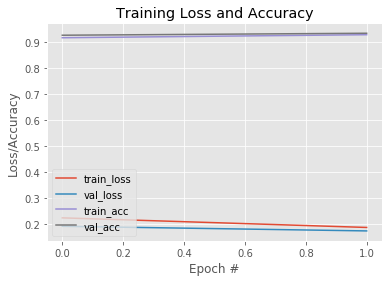

In [24]:
plot_training(history, 2)

## Model training with NSL and evaluation

Example taken from: https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist

In [0]:
model = get_model(nsl=True)
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_model = nsl.keras.AdversarialRegularization(model, adv_config=adv_config)
adv_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
# start = time.time()
# h = adv_model.fit({'feature': X_train, 'label': y_train},
#                   validation_data=(X_val, y_val),
#                   batch_size=128, epochs=2, verbose=1)
# print("Took {0:.2f} seconds".format(time.time() - start))

In [0]:
# start = time.time()
# h = adv_model.fit({'feature': X_train, 'label': y_train},
#                   validation_data={'feature': X_val, 'label': y_val},
#                   batch_size=128, epochs=2, verbose=1)
# print("Took {0:.2f} seconds".format(time.time() - start))

The `validation_data` argument does not seem to play nice. I have propagated this a [GitHub issue](https://github.com/tensorflow/tensorflow/issues/32279). Will update accordingly. 

In [26]:
start = time.time()
history = adv_model.fit({'feature': X_train, 'label': y_train},
                  batch_size=128, epochs=2, verbose=1)
print("Took {0:.2f} seconds".format(time.time() - start))

W0906 07:57:31.702005 139837888120704 training_utils.py:1347] Output output_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to output_1.


Train on 42500 samples
Epoch 1/2
42500/42500 [==============================] - 39s 906us/sample - loss: 0.2708 - binary_crossentropy: 0.2215 - binary_accuracy: 0.9165 - adversarial_loss: 0.2444
Epoch 2/2
42500/42500 [==============================] - 36s 837us/sample - loss: 0.2261 - binary_crossentropy: 0.1851 - binary_accuracy: 0.9285 - adversarial_loss: 0.2092
Took 74.79 seconds


In [27]:
# Third one is the accuracy
adv_model.evaluate({'feature': X_test, 'label': y_test})

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.22024206206798552, 0.17910552, 0.9307101, 0.20583344]